# Q-Learning for Continuous Observation Spaces

Previously we looked at solving the Taxi problem with Q-Learning. The core idea behind Q-Learning is creating a table, the Q-Table, the will represent what the agent has learned over time.

The Q-table is a matrix where we have a row for every state and a column for every action. It's first initialized to 0, and then values are updated during training.

The agent learns by looking at the reward for taking an action in the current state, then updating a Q-value to remember if that action was beneficial.

These Q-values are stored in the Q-table. They map to a (state, action) combination.

A Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. Better Q-values imply better chances of getting greater rewards.

### The Problem

In order to build a Q-Table with a row for every possible state and a column for every possible action, the states and actions have to be countable (discrete). However, many real-world situations are not discrete, they are represented by continuous values. This means there are literally an infinite number of possible states.

So how can we use Q-Learning to solve continuous problems?

### The Solution

One way to solve this problem is to map the range of continuous values to a discrete number of "buckets". This is known as quantization: [wikipedia](https://en.wikipedia.org/wiki/Quantization_(signal_processing)).

We can use quantization to map our continuos inputs to any number of countable states, however many we think we may need. For this case we'll call these countable states "buckets". The fewer buckets we have, the less accurate our model will be. At the same time, we don't want too many buckets because our Q-Table could become too large.

For example, having 10 million buckets to represent the environment state would give us high accuracy but the Q-Table would have 10 million rows multiplied by how many possible actions there are. This would require a lot of memory to store the Q-Table and probably hinder performance.

So the goal becomes: Find a reasonable number of buckets that can still accurately represent the observation space.

How do we know if we are accurately representing the observation space? We see if the agent can solve the task at hand. If the Q-Learning agent cannot solve the problem, we probably need to give it more information by breaking the inputs into more buckets.

## CartPole

Let's investigate solving a problem with a continuous observation space, the CartPole problem.

Previously we saw solutions to the CartPole problem without using reinforcement learning. We looked at random search and a simplistic hill-climbing appoarch. The random search solution did better so we'll start by using that as are benchmark to compare our Q-Learning solution to.

### Review of Gym's Interface

The core gym interface is env, which is the unified environment interface. The following are the env methods that will be helpful:

* **env.reset:** Resets the environment and returns a random initial state.
* **env.step(action):** Step the environment by one timestep. Returns:
  * **observation:** Observations of the environment
  * **reward:** If your action was beneficial or not
  * **done:** Indicates if we have successfully picked up and dropped off a passenger, also called one episode
  * **info:** Additional info such as performance and latency for debugging purposes
* **env.render:** Renders one frame of the environment (helpful in visualizing the environment)

In [ ]:
import gym
import numpy as np

Let's start by looking at the observation space and action space for this environment.

In [ ]:
env = gym.make("CartPole-v1")
print(env.observation_space)
print(env.action_space)

We have 4 continuos variables for the observation space and 2 discrete variables for the action space. It's typically useful to know the range of the values you are working with.

In gym, if you are working with a continuous space (observation or action) then you can call '.low' and '.high' to get the lowest values and highest values, respectively.

When working in a discrete space then you can call '.n' to get the number of discrete variables there are.

In [ ]:
env = gym.make("CartPole-v1")

print("Observation Space:") # We know the observation space is continuous so we'll use '.low' and '.high' to get the range
print("> Lowest values: {}".format(env.observation_space.low))
print("> Highest values: {}".format(env.observation_space.high))
print("> Range: {}".format(env.observation_space.high - env.observation_space.low))

print("\nAction Space:") # We know the action space is discrete so we'll use '.n' to get the range
print("> Range: {}".format(env.action_space.n))

Note that the range for the second and fourth observation variables is infinity. To make this work with Q-Learning we'll have to come up with more reasonable bounds. We will worry about that soon.

### Random Search Solution

As before we will be doing a linear combination appoarch, creating one weight parameter for every observation variable we have. Then we'll randomly pick new parameters until we find a set that can solve the problem.

Below we define a function that performs random search for the CartPole problem. The code is slightly modified from Lab 1. This time we can change the goal to be achieved by the agent.

We also add a 'render_episode' function that we can use to see how well a trained agent performs.

In [ ]:
'''
Arguments:
    env - An instance of the CartPole environment
    num_episodes - Number of episodes to run environment
    goal - Number of timesteps for Agent to last to be considered a success (default is 200)
'''
def random_search(env, num_episodes, goal=200):
    parameters = np.random.rand(4) * 2 - 1  # Initialize parameters

    bestparams = None
    bestreward = 0
    
    for episodes in range(1, num_episodes+1):  # run 'num_episodes' episodes
        parameters = np.random.rand(4) * 2 - 1
        
        observation = env.reset()
        totalreward = 0
        for _ in range(goal):
            action = 0 if np.matmul(parameters,observation) < 0 else 1
            observation, reward, done, info = env.step(action)
            totalreward += reward
            if done:
                break
        reward = totalreward

        if reward > bestreward:  # Check for new personal best
            bestreward = reward
            bestparams = parameters  # Remember winning parameters
            # considered solved if the agent lasts 'goal' timesteps
            # Stop training if solved
            if reward >= goal:
                break
    env.close() # Cleanup environment
    return episodes, bestreward, bestparams

def run_episode(env, parameters, goal=200, render=False):
    observation = env.reset()
    totalreward = 0
    for _ in range(goal):
        if(render):
            env.render()
        action = 0 if np.matmul(parameters,observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    env.close() # Cleanup environment
    return totalreward

Let's run random search for 2000 episodes and see if it can solve the problem. This time rather than a goal of lasting for 200 timesteps, we'll make it a little more challenging. The agent will have to last for 1,000 timesteps.

In [ ]:
env = gym.make("CartPole-v1").env  # Setup fresh environment

In [ ]:
e, r, p = random_search(env, 2000, goal=1000)
print("Took {} episodes to solve.".format(e))
print("Parameters used to solve: {}".format(p))

Now we can render an episode using the parameters stored in the variable 'p'. We'll set the goal to 500 for rendering so it doesn't run for too long. Doing 500 timesteps should take ~10 to ~20 seconds.

In [ ]:
%%time
env = gym.make("CartPole-v1").env  # Setup fresh environment
r = run_episode(env, p, goal=500, render=True)
print("Earned reward of {}".format(r))

This time to evaluate the model, let's see how well it generalizes to a harder problem.

We trained it one lasting for 1,000 timesteps. If it has generalized well then it should be able to last much longer than that. For this test we will set the goal to 2,000 timesteps. We will evaluate it by seeing how many times out of 100 it passes this test.

In [ ]:
reward_list = []
passed_count = 0
test_goal = 2000
for step in range(100):  # Run test 100 times
    r = run_episode(env, p, goal=test_goal, render=False)
    if r >= test_goal:
        passed_count += 1
    reward_list.append(r)  # Storing results in reward_list
    
print("Model passed the test with a success rate of {}%".format(passed_count))

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.hist(reward_list)
fig.suptitle('Histogram of Random Search', fontsize=20)
plt.xlabel('Reward Earned', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

### Q-Learning Solution

To get started with a Q-Learning approach we need to come up with a way to quantinize the input. Normally you would have to experiment a bit to see how many buckets you should use to represent the state. For this demonstration we'll use values that I found to work out well.

Recall that there are four variables. These variables represent: position of the cart, velocity of the cart, angle of the pole, and angluar velocity of the pole. We'll call these: (x, x', theta, theta'). The table below shows how many buckets we'll use for each variable.

| Variable | Number of Buckets
| :- | -:
| **x** | 1
| **x'** | 1
| **theta** | 6
| **theta'** | 3

Below we come up with a convenient way to store this information.

In [ ]:
import gym
import numpy as np
import random
import math

In [ ]:
## Initialize the "Cart-Pole" environment
env = gym.make('CartPole-v0')

# Number of discrete states (bucket) per state dimension
NUM_BUCKETS = (1, 1, 6, 3)  # (x, x', theta, theta')

# Number of discrete actions
NUM_ACTIONS = env.action_space.n # (left, right)

# Index of the action
ACTION_INDEX = len(NUM_BUCKETS)

# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
## This gives us a list of (low, high) pairs. In other words, the range for each variable
## STATE_BOUNDS[0]: x
## STATE_BOUNDS[1]: x'
## STATE_BOUNDS[2]: theta
## STATE_BOUNDS[3]: theta'

print(STATE_BOUNDS)


Recall from earlier that we noticed x' and theta' have a range of infinity.

In [ ]:
print("Range for x': {}".format(STATE_BOUNDS[1][0] - STATE_BOUNDS[1][1]))
print("Range for theta': {}".format(STATE_BOUNDS[3][0] - STATE_BOUNDS[3][1]))

To avoid this infinity problem, we'll change the bounds to something more reasonable for these velocity values. Think of these values as the largest extremes we would need to consider for this environment. Explaining why these new bounds make sense in this case is outside the scope of the class.

In [ ]:
STATE_BOUNDS[1] = [-0.5, 0.5]
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]

Now that we have defined our buckets and boundaries for the continuous variables, we can define a function that looks at a set of those values and decides what bucket each variable value falls into.

This function may be pretty confusing but don't worry too much about it. You'll be able to reuse this function for any number of buckets.

In [ ]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)): # For every variable in the observation space:
        if state[i] <= STATE_BOUNDS[i][0]:    # if the value is less than or equal to the lower bound
            bucket_index = 0                  # put it the first bucket
        elif state[i] >= STATE_BOUNDS[i][1]:  # if the value is greater than or equal to the higher bound
            bucket_index = NUM_BUCKETS[i] - 1 # put it in the last bucket
        else:                                 # otherwise: determine which bucket the value falls into.
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

Let's look at an example to see how the 'state_to_bucket' function works.

In [ ]:
## Initialize the "Cart-Pole" environment
env = gym.make('CartPole-v0')

state = env.reset()
buckets = state_to_bucket(state)
print(state)
print(buckets)

Now we have a method of mapping the continuous variables to discrete states. With this we can implement Q-Learning as we did with the taxi problem.

### Training the Agent

The code below defines the state variables we were talking about. It also defines a few helper functions to make training easier. The 'q_learning_train' function contains the base Q-Learning process. It is very similiar to the Taxi Q-Learning solution.

In [1]:
import gym
import numpy as np
import random
import math
from IPython.display import clear_output


## Initialize the "Cart-Pole" environment
env = gym.make('CartPole-v0').env

## Defining the environment related constants

# Number of discrete states (bucket) per state dimension
NUM_BUCKETS = (1, 1, 6, 3)  # (x, x', theta, theta')
# Number of discrete actions
NUM_ACTIONS = env.action_space.n # (left, right)
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
STATE_BOUNDS[1] = [-0.5, 0.5]
STATE_BOUNDS[3] = [-math.radians(50), math.radians(50)]
# Index of the action
ACTION_INDEX = len(NUM_BUCKETS)

## Creating a Q-Table for each state-action pair
q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,))

## Learning related constants
MIN_EXPLORE_RATE = 0.01
MIN_LEARNING_RATE = 0.1

## Defining the simulation related constants
NUM_EPISODES = 1000
MAX_T = 1200
STREAK_TO_END = 120

def q_learning_train(env, num_episodes, goal=200):

    ## Instantiating the learning related parameters
    learning_rate = get_learning_rate(0)
    explore_rate = get_explore_rate(0)
    discount_factor = 0.99  # since the world is unchanging

    num_streaks = 0

    for episode in range(1, num_episodes+1):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = state_to_bucket(obv)
        
        totalreward = 0

        for t in range(MAX_T):
            #env.render()

            # Select an action
            action = select_action(state_0, explore_rate)

            # Execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            state = state_to_bucket(obv)

            totalreward += reward
            
            # Update the Q based on the result
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate*(reward + discount_factor*(best_q) - q_table[state_0 + (action,)])

            # Setting up for the next iteration
            state_0 = state

            if done:
                if (t >= goal):
                    num_streaks += 1
                else:
                    num_streaks = 0
                break
                
        if episode%100 == 0:
            clear_output(wait=True)
            print("Episode {}/{} finished with reward: {}".format(episode, num_episodes, totalreward))

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            print("Solved 120 times consecutively after {} episodes".format(episode))
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)

    return episode

def select_action(state, explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = np.argmax(q_table[state])
    return action


def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(1, 1.0 - math.log10((t+1)/25)))

def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(0.5, 1.0 - math.log10((t+1)/25)))

def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


With these functions defined, we can now actually train the agent. It will take a bit longer than the random search function.

In [ ]:
%%time
episode_count = q_learning_train(env, 1000, 1000)

Let's save the trained Q-Table so we don't have to train again.

In [ ]:
trained_q_table = q_table
print(trained_q_table)

### Evaluating the agent

Let's evaluate the performance of our agent. We don't need to explore actions any further, so now the next action is always selected using the best Q-value.

In [2]:
def run_q_episode(env, q_table, goal=200, render=False):

    # Reset the environment
    obv = env.reset()

    # the initial state
    state_0 = state_to_bucket(obv)
    
    totalreward = 0

    for t in range(goal):
        if render:
            env.render()

        # Select an action
        action = np.argmax(q_table[state_0])

        # Execute the action
        obv, reward, done, _ = env.step(action)

        # Observe the result
        state = state_to_bucket(obv)
        
        totalreward += reward

        # Setting up for the next iteration
        state_0 = state
        
        if done:
            break
        
    env.close()
    return totalreward

In [ ]:
## Initialize the "Cart-Pole" environment
env = gym.make('CartPole-v0').env

In [ ]:
reward_list = []
passed_count = 0
test_goal = 2000
for step in range(100):  # Run test 100 times
    r = run_q_episode(env, trained_q_table, goal=test_goal, render=False)
    if r >= test_goal:
        passed_count += 1
    reward_list.append(r)  # Storing results in reward_list
    
print("Model passed the test with a success rate of {}%".format(passed_count))

In [ ]:
fig = plt.figure()
plt.hist(reward_list)
fig.suptitle('Histogram of Q-Learning', fontsize=20)
plt.xlabel('Reward Earned', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

Surprisingly, it looks like the random search method still out-performs the Q-Learning method. However, we only trained this model for 1,000 episodes. Let's see how it does after 10,000 episodes of training. I've done this for you so you won't have to wait for a long time. (It took about 12 minutes to train for 10k episodes).

The code below loads my saved Q-Table.

In [ ]:
import pickle

In [ ]:
trained_10k_table = pickle.load(open("10k_table.p", "rb"))

Now let's run the test again with this Q-Table.

In [9]:
reward_list = []
passed_count = 0
test_goal = 2000
for step in range(100):  # Run test 100 times
    #r = run_q_episode(env, trained_10k_table, goal=test_goal, render=False)
    r = run_q_episode(env, q_table, goal=test_goal, render=False)
    if r >= test_goal:
        passed_count += 1
    reward_list.append(r)  # Storing results in reward_list
    
print("Model passed the test with a success rate of {}%".format(passed_count))

Model passed the test with a success rate of 23%


In [11]:
!pip install matplotlib

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


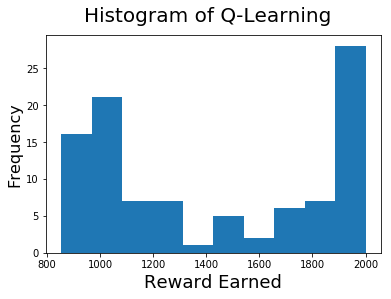

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(reward_list)
fig.suptitle('Histogram of Q-Learning', fontsize=20)
plt.xlabel('Reward Earned', fontsize=18)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In [3]:
## Initialize the "Cart-Pole" environment
env = gym.make('CartPole-v0').env

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
import pickle
trained_10k_table = pickle.load(open("10k_table.p", "rb"))

In [4]:
#q_table = trained_10k_table
print(q_table)

[[[[[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]]]]]


In [5]:
%%time
episode_count = q_learning_train(env, 100000, 3000)

Episode 100000/100000 finished with reward: 927.0
Wall time: 1h 1min 37s


In [7]:
import pickle
pickle.dump(q_table, open("100k-v2_table.p", "wb"))

In [8]:
print(q_table)

[[[[[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]

   [[48.42954221 94.15553738]
    [13.20993941 92.97624677]
    [ 0.          0.        ]]

   [[99.99997022 99.67674374]
    [99.99997114 99.99986778]
    [99.97987612 99.99997097]]

   [[99.99997093 99.99618855]
    [99.99978382 99.99997105]
    [99.90718789 99.99997017]]

   [[ 2.92303887 13.42978732]
    [96.81188301 16.45716758]
    [96.974966   76.90964663]]

   [[ 0.          0.        ]
    [ 0.          0.        ]
    [ 0.          0.        ]]]]]


In [ ]:
%%time
episode_count = q_learning_train(env, 100000, 1000)

In [ ]:
pickle.dump(q_table, open("200k_table.p", "wb"))